In [166]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import math

# Part 1. Toy dataset "Will They? Won't They?"

In [167]:
# Create dataframe with dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Some feature values are present in train and absent in test and vice-versa.
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [168]:
features = ['Looks', 'Alcoholic_beverage','Eloquence','Money_spent']

In [169]:
df_train = {}
df_train['Looks'] = ['handsome', 'handsome', 'handsome', 'repulsive',
                         'repulsive', 'repulsive', 'handsome'] 
df_train['Alcoholic_beverage'] = ['yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes']
df_train['Eloquence'] = ['high', 'low', 'average', 'average', 'low',
                                   'high', 'average']
df_train['Money_spent'] = ['lots', 'little', 'lots', 'little', 'lots',
                                  'lots', 'lots']
df_train['Will_go'] = LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,1,0,0,1,0,1,0,0,1
1,1,1,0,0,1,0,0,1,1,0
2,0,1,0,1,0,1,0,0,0,1
3,1,0,1,1,0,1,0,0,1,0
4,1,0,1,0,1,0,0,1,0,1
5,0,0,1,0,1,0,1,0,0,1
6,0,1,0,0,1,1,0,0,0,1


In [170]:
df_train.sort_values(by='Money_spent_lots',ascending=True)

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
1,1,1,0,0,1,0,0,1,1,0
3,1,0,1,1,0,1,0,0,1,0
0,0,1,0,0,1,0,1,0,0,1
2,0,1,0,1,0,1,0,0,0,1
4,1,0,1,0,1,0,0,1,0,1
5,0,0,1,0,1,0,1,0,0,1
6,0,1,0,0,1,1,0,0,0,1


In [171]:
df_test = {}
df_test['Looks'] = ['handsome', 'handsome', 'repulsive'] 
df_test['Alcoholic_beverage'] = ['no', 'yes', 'yes']
df_test['Eloquence'] = ['average', 'high', 'average']
df_test['Money_spent'] = ['lots', 'little', 'lots']
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,1,0,1,0,1,0,0,1
1,1,0,0,1,0,1,1,0
2,0,1,0,1,1,0,0,1


In [172]:
# Some feature values are present in train and absent in test and vice-versa.
y = df_train['Will_go']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Looks_handsome,Looks_repulsive,Eloquence_average,Eloquence_high,Money_spent_little,Alcoholic_beverage_yes,Money_spent_lots,Alcoholic_beverage_no
0,1,0,0,1,0,1,1,0
1,1,0,0,0,1,1,0,0
2,1,0,1,0,0,0,1,1
3,0,1,1,0,1,0,0,1
4,0,1,0,0,0,1,1,0
5,0,1,0,1,0,1,1,0
6,1,0,1,0,0,1,1,0


In [173]:
df_test

,Looks_handsome,Looks_repulsive,Eloquence_average,Eloquence_high,Money_spent_little,Alcoholic_beverage_yes,Money_spent_lots,Alcoholic_beverage_no
0,1,0,1,0,0,0,1,1
1,1,0,0,1,1,1,0,0
2,0,1,1,0,0,1,1,0



## Draw a decision tree (by hand or in any graphics editor) for this dataset. Optionally you can also implement tree construction and draw it here.

### 1. What is the entropy S0 of the initial system? By system states, we mean values of the binary feature "Will_go" - 0 or 1 - two states in total.

### 2. Let's split the data by the feature "Looks_handsome". What is the entropy S1 of the left group - the one with "Looks_handsome". What is the entropy S2 in the opposite group? What is the information gain (IG) if we consider such a split?

In [174]:
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)
clf_tree.fit(df_train, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

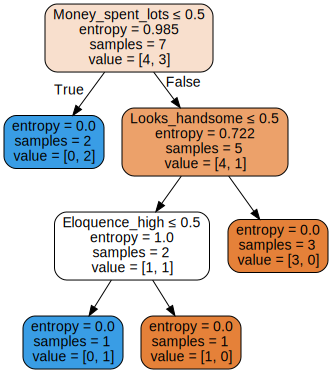

In [175]:
import graphviz
from sklearn.tree import export_graphviz
dot_data = export_graphviz(clf_tree, feature_names=df_train.columns,out_file=None, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [176]:
looks_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)
looks_tree.fit(df_train['Looks_handsome'].values.reshape(-1, 1), y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

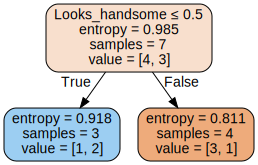

In [177]:
dot_data2 = export_graphviz(looks_tree, feature_names=['Looks_handsome'],\
                            out_file=None, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data2)
graph

### Entropy( Looks_handsome ≤ 0.5)

In [178]:
s0 = (-4/7)*math.log(4/7, 2)-(3/7)*math.log(3/7, 2)
print('s0 =',s0)

s0 = 0.9852281360342516


### Answer(1): 0,985

In [179]:
s1 = (-3/4)*math.log(3/4, 2)-(1/4)*math.log(1/4, 2)
print('s1 =',s1)

s1 = 0.8112781244591328


In [180]:
s2 = (-1/3)*math.log((1/3), 2)-(2/3)*math.log((2/3), 2)
print('s2 =',s2)

s2 = 0.9182958340544896


### Information gain( Looks_handsome ≤ 0.5)

In [181]:
IG = s0 - (4/7)*s1 - (3/7)*s2
print('IG =',IG)

IG = 0.12808527889139454


### Answer(2): S1 = 0,811, S2 = 0,918, IG = 0,128

# Part 2. Functions for calculating entropy and information gain.

In [182]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

<img src = decision_tree3.png >

<img src = 'decision_tree4.png'>

In [183]:
# two groups
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 blue and 6 yellow

## Implement a function to calculate the Shannon Entropy

In [184]:
def entropy(a_list):
    sum = 0    
    for i in set(a_list):
        s0 = -(a_list.count(i)/len(a_list))*math.log(a_list.count(i)/len(a_list), 2)
        sum +=s0
    return sum

In [185]:
print('Entropy b =',entropy(balls)) # 9 blue and 11 yellow
print('Entropy bl =',entropy(balls_left)) # 8 blue and 5 yellow
print('Entropy br =',entropy(balls_right)) # 1 blue and 6 yellow
print('Entropy 6-sided dice =',entropy([1,2,3,4,5,6])) # entropy of a fair 6-sided dice

Entropy b = 0.9927744539878084
Entropy bl = 0.961236604722876
Entropy br = 0.5916727785823275
Entropy 6-sided dice = 2.584962500721156


### Answer(3): 0,961

### Answer(4): 2.585

In [186]:
# information gain calculation
def information_gain(root, left, right):
    IG = entropy(root) - (len(left)/len(root))*entropy(left) - (len(right)/len(root))*entropy(right)
    return IG

In [187]:
information_gain(balls, balls_left, balls_right)

0.16088518841412436

### Answer(5): 0,161

In [188]:
#def best_feature_to_split(X, y):
#    ''' Выводит прирост информации при разбиении по каждому признаку'''
#    
    # Ваш код здесь
#    pass



In [189]:
#def fact(num):
#    if num == 0: 
#        return 1 # По договоренности факториал нуля равен единице
#    else:
#        return num * fact(num - 1) # возвращаем результат произведе

# Part 3. The "Adult" dataset

In [190]:
data_train = pd.read_csv('../data/adult_train.csv', sep=';')

In [191]:
data_test = pd.read_csv('../data/adult_test.csv', sep=';')

In [192]:
# necessary to remove rows with incorrect labels in test dataset
data_test = data_test[(data_test['Target'] == ' >50K.') | (data_test['Target']==' <=50K.')]

# encode target variable as integer
data_train.loc[data_train['Target']==' <=50K', 'Target'] = 0
data_train.loc[data_train['Target']==' >50K', 'Target'] = 1

data_test.loc[data_test['Target']==' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target']==' >50K.', 'Target'] = 1

In [193]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281,NaN,NaN,NaN,189436,105715,13492,116736,177831,238384,1.4904e+06
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281,NaN,NaN,NaN,10.0729,2.56755,1,9,10,12,16
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [194]:
data_train['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

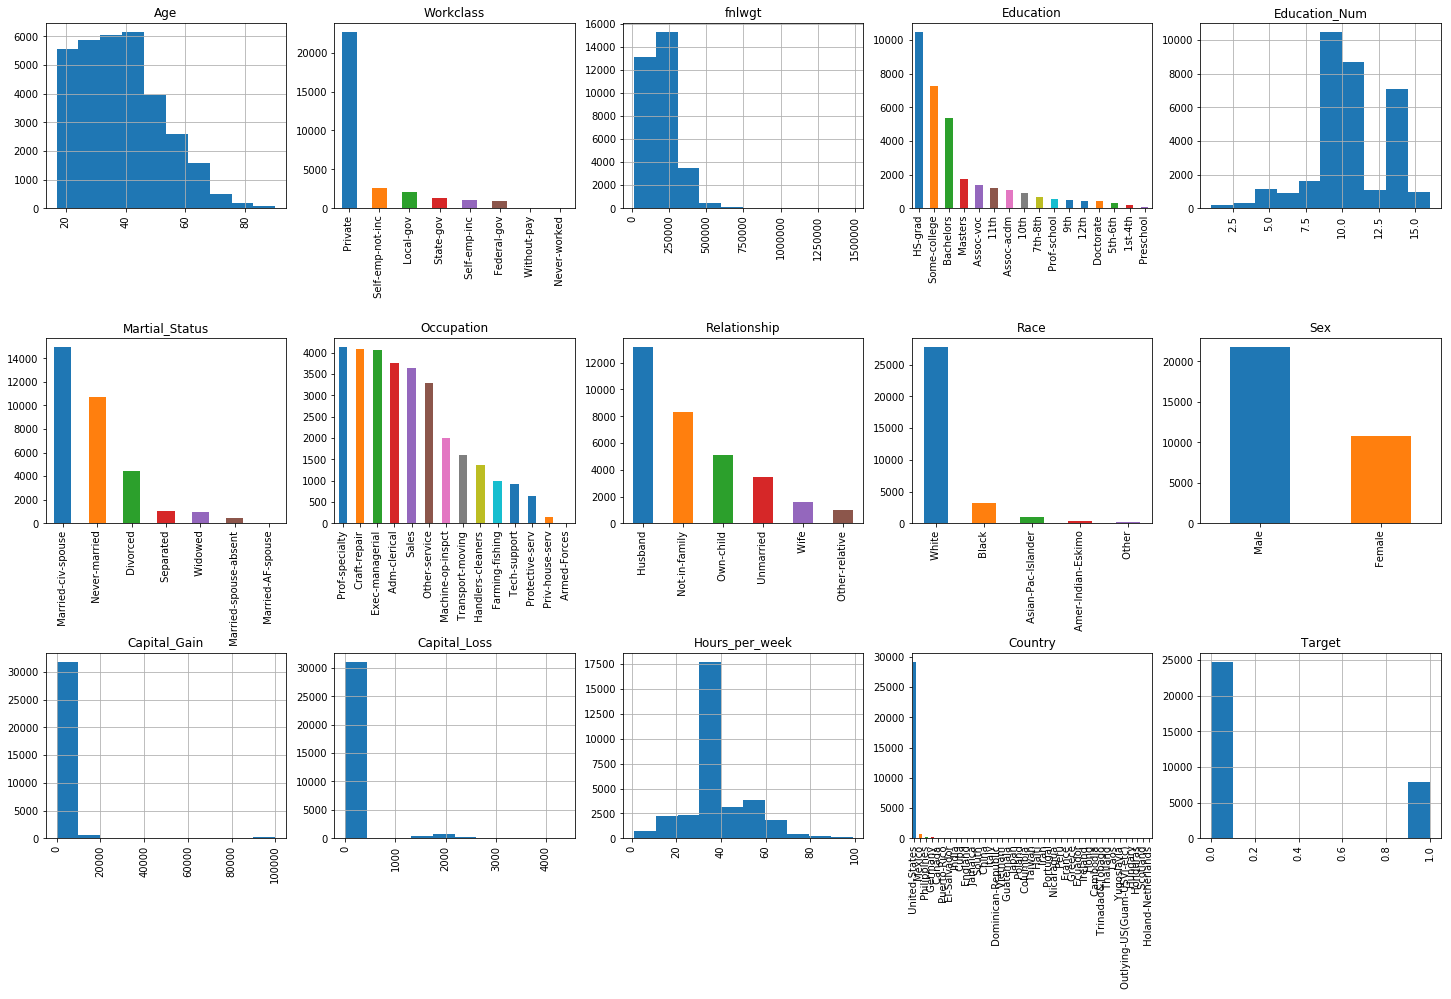

In [195]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(data_train.shape[1]) / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == np.object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [196]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target             int64
dtype: object

In [197]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target              int64
dtype: object

In [198]:
data_test['Age'] = data_test['Age'].astype(int)

In [199]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

In [200]:
# choose categorical and continuous features from data

categorical_columns = [c for c in data_train.columns 
                       if data_train[c].dtype.name == 'object']
numerical_columns = [c for c in data_train.columns 
                     if data_train[c].dtype.name != 'object']

print('categorical_columns:', categorical_columns)
print('numerical_columns:', numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Target']


In [201]:
# fill missing data

for c in categorical_columns:
    data_train[c].fillna(data_train[c].mode(), inplace=True)
    data_test[c].fillna(data_train[c].mode(), inplace=True)
    
for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)

In [202]:
data_train = pd.concat([
    pd.get_dummies(data_train[categorical_columns]),
    data_train[numerical_columns]], axis=1)

data_test = pd.concat([
    pd.get_dummies(data_test[categorical_columns]),
    data_test[numerical_columns]], axis=1)

In [203]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [204]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

In [205]:
data_test['Country_ Holand-Netherlands'] = 0

In [206]:
set(data_train.columns) - set(data_test.columns)

set()

In [207]:
data_train.head(2)

,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay,Education_ 10th,Education_ 11th,...,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target
0,0,0,0,0,0,0,1,0,0,0,...,1,0,0,39,77516,13,2174,0,40,0
1,0,0,0,0,0,1,0,0,0,0,...,1,0,0,50,83311,13,0,0,13,0


In [208]:
data_test.head(2)

,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay,Education_ 10th,Education_ 11th,...,Country_ Vietnam,Country_ Yugoslavia,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Country_ Holand-Netherlands
1,0,0,0,1,0,0,0,0,0,1,...,0,0,25,226802,7,0,0,40,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,38,89814,9,0,0,50,0,0


In [209]:
X_train = data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test = data_test.drop(['Target'], axis=1)
y_test = data_test['Target']


# 3.1 Decision tree without parameter tuning

## Train a decision tree (DecisionTreeClassifier) with a maximum depth of 3, and evaluate the accuracy metric on the test data. Use parameter random_state = 17 for results reproducibility.


In [210]:
tree = DecisionTreeClassifier(max_depth = 3,random_state=17)
tree.fit(X_train, y_train)
tree_predictions = tree.predict(X_test)
accuracy_score(y_test, tree_predictions)

0.7904305632332166

### 6. What is the test set accuracy of a decision tree with maximum tree depth of 3 and random_state = 17?
### Answer(6): 0.79

# 3.2 Decision tree with parameter tuning

## Train a decision tree (DecisionTreeClassifier, random_state = 17). Find the optimal maximum depth using 5-fold cross-validation (GridSearchCV).


In [211]:
tree_params = {'max_depth': range(2,11)}

locally_best_tree = GridSearchCV(tree, tree_params,cv=5, n_jobs=-1,verbose=True)                     

locally_best_tree.fit(X_train, y_train);

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.2s finished


In [212]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 9}
Best cross validaton score 0.8561469242345137


### Best params: {'max_depth': 9}
### Best cross validaton score 0.8561469242345137

In [213]:
tuned_tree = DecisionTreeClassifier(max_depth = 9,random_state=17)
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test)
accuracy_score(y_test, tuned_tree_predictions)

0.7879737116884712

### 7. What is the test set accuracy of a decision tree with maximum tree depth of 9 and random_state = 17?
### Answer(7): 0.788